In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from werkzeug.wrappers import Request, Response

In [22]:
import numpy as np
import pandas as pd

In [23]:
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# EXPloratory Climate Analysis

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and date, then plot the results. 
# Calculate the date 1 year ago from the last data point in the database
date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
order_by(Measurement.date).statement 

In [31]:
# Save the query results as a Pandas DataFrame and set the index to the date column.
date_prcp_df = pd.read_sql(date_prcp_query, engine).dropna()
date_prcp_df.head(5)

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


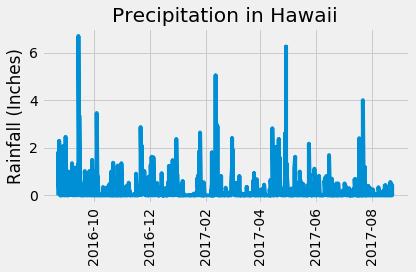

In [32]:
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df['date']  = pd.to_datetime(date_prcp_df['date'])
plt.plot(date_prcp_df['date'], date_prcp_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [34]:
# # Design a query to show how many stations are available in this dataset?
station_boolean = session.query(Measurement.station).distinct().count()== session.query(Station.station).distinct().count()
if station_boolean:
    num_station = session.query(Measurement.station).distinct().count()
    print(f'The number of stations = {num_station}')
else:
    print('your database is not NSYNC')

The number of stations = 9


In [35]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_id = desc_observ[0][0]
station_name = session.query(Station.name).filter(Station.station==desc_observ[0][0]).all()
print(f'The most active stations is {station_name[0][0]}')

The most active stations is WAIHEE 837.5, HI US


In [36]:
# List the stations and the counts in descending order.
desc_observ = engine.execute('select station, count(station) from measurement group by station order by count(station) desc').fetchall()
desc_observ

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

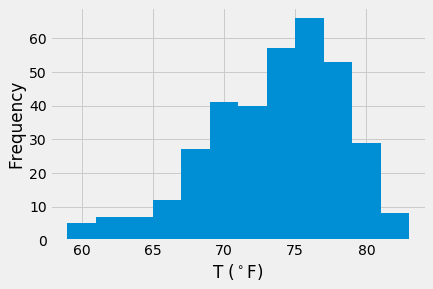

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

tobs_query = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
filter(Measurement.station==station_id).\
order_by(Measurement.date).statement 

tobs_df = pd.read_sql(tobs_query, engine).dropna()
tobs_df.head(5)

x = tobs_df['tobs']

plt.hist(x, bins=12)
plt.xlabel(r'T ($^\circ$F)')
plt.ylabel('Frequency')
plt.show()


In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
            
    query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    for Tmin, Tmax, Tavg in query:
        print("From", start_date, "to", end_date, "the minimum temperature is",
              Tmin,'\u00b0'"F, the maximum temperature is", Tmax,'\u00b0'"F, and the average temeperature is",
              "{0:.1f}".format(round(Tavg,1)),'\u00b0'"F.")

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

From 2012-02-28 to 2012-03-05 the minimum temperature is 62.0 °F, the maximum temperature is 74.0 °F, and the average temeperature is 69.6 °F.
None


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
start_date = '2017-06-28'
end_date = '2017-07-07'
vacay_query = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# for your trip using the previous year's data for those same dates.
vacay_temps = pd.DataFrame(vacay_query, columns=['Date', 'Tobs'])
vacay_temps.head()

,Date,Tobs
0,2017-06-28,79.0
1,2017-06-29,79.0
2,2017-06-30,75.0
3,2017-07-01,80.0
4,2017-07-02,80.0


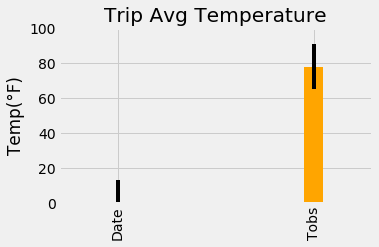

In [40]:
avg_temp = vacay_temps.mean()
temp_diff = (vacay_temps["Tobs"].max()-vacay_temps["Tobs"].min())


p = avg_temp.plot(legend=False,kind="bar",color="orange",yerr=temp_diff, width=0.1, figsize=(5,3))
p.set_title("Trip Avg Temperature")
p.set_ylabel("Temp(°F)")
p.set_ylim(0,100)
plt.show()